# Task 2 

## Problem Statement


_Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability._

**Requirements:**
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

**Bonus:**
How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?

### Approach
Consider a system of two qubits (q1 and q2) in the following states:

q1: $\lvert\psi_1\rangle = \frac{1}{\sqrt{2}}\lvert0\rangle + \frac{1}{\sqrt{2}}e^{i\phi}\lvert1\rangle$

q2: $\lvert\psi_2\rangle = \lvert1\rangle$

$\lvert\psi^{'}\rangle =$ q1 $\otimes$ q2 $= \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}e^{i\phi}\lvert11\rangle$


Now, applying a [CNOT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html#qiskit.circuit.library.CXGate) gate from q1 to q2 generates the required state with 50% probability of $\lvert01\rangle$ and $\lvert10\rangle$ each:
$$\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}e^{i\phi}\lvert10\rangle$$

If we start with a qubit in state |0>, applying [RY](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RYGate.html) followed [RX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) gate can be represented by the following process:

$$
\lvert0\rangle
\xrightarrow{RY(\theta_1)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2}) \\
    sin(\frac{\theta_1}{2})
\end{bmatrix}
\xrightarrow{RX(\theta_2)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) - isin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) \\
    sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})-icos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) 
\end{bmatrix}
$$

Our target is to start with randomly initialized parameters ([$\theta_1, \theta_2$]) for each qubit and arrive at values which would transform:

for q1:	$\lvert0\rangle \xrightarrow{RY(\theta_11) RX(\theta_12)} \lvert\psi_1\rangle$

for q2: $\lvert0\rangle \xrightarrow{RY(\theta_21) RX(\theta_22)} \lvert 1\rangle$

### Probability function

Our parametrized final state after RX and RY can be written as
$$
\lvert\psi_{param}\rangle = 
\begin{bmatrix} 
    cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) - isin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) \\
    sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})-icos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) 
\end{bmatrix}
$$
Thus the probabilities using Born’s rule:

$P_0 = cos^2(\frac{\theta_1}{2})cos^2(\frac{\theta_2}{2}) + sin^2(\frac{\theta_1}{2})sin^2(\frac{\theta_2}{2})$

$P_1 = cos^2(\frac{\theta_1}{2})sin^2(\frac{\theta_2}{2}) + sin^2(\frac{\theta_1}{2})cos^2(\frac{\theta_2}{2})$

### Cost function
Since we can only measure the probabilities of a state, the cost function will be defined in terms of actual probabilities $(P0 , P1)$ and expected probabilities $(E0 , E1)$

Cost = $(P_0 – E_0) ^2 + (P_1 – E_1) ^2$

Since expected probabilities are different, cost function will be defined separately.

For q1: cost = $(P_0 – 0.5) ^2 + (P_1 – 0.5) ^2$

For q2: cost = $(P_0 – 1) ^2 + (P_1 – 0) ^2$

### Gradient Descent
The gradient descent update formula is written as:
$\theta_{i} = \theta_{i} - \frac{\mathrm{d} (cost)}{\mathrm{d}\theta_i}$

Using chain rule,
$\frac{\mathrm{d} (cost)}{\mathrm{d}\theta_i} = 2(P_0 – E_0)*\frac{\mathrm{d} P_0}{\mathrm{d}\theta_i} + 2*(P_1 – E_1)*\frac{\mathrm{d} P_1}{\mathrm{d}\theta_i}$
where $P_0 and P_1$ have been defined above in the probability function 

All these calculations will be performed symbolically using SymPy.

### Environment
We will use *Qiskit* as the main quantum library. The equations will be expressed symbolically using *SymPy* and we will write a custom loop for gradient descent

In [ ]:
# installing a few dependencies
!pip install --upgrade matplotlib==3.2.0
!pip install --upgrade qiskit==0.19.6

# the output will be cleared after installation
from IPython.display import clear_output
clear_output()

In [1]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.quantum_info import Statevector
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_state_qsphere
from qiskit.test.mock import FakeVigo
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

import numpy as np

from sympy import *

In [5]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)
backend=Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2020-09-25 16:40:48,975: Credentials are already in use. The existing account in the session will be replaced.


### Qubit class
We will create a class which will contain attributes of a single qubit

**$inp$** : since both qubits start in $\lvert0\rangle$ state, the probability initial state is defined as [1, 0]

**$target$** : for q1 the target state will be $[0.5, 0.5]$ and $[0,1]$ for q2

**$t1$** : symbolic parameter for Ry gate

**$t2$** : symbolic parameter for Rx gate

**$P_0$** : symbolic observed probability of |0>

**$P_1$** : symbolic observed probability of |1>

**$thetas$** : a pair of randomly initialized $t1$ and $t2$ between $[0, 2\pi]$. Updated at each step of gradient descent

**$sym\_state$** : the final state of the qubit will be represented in terms of t1 and t2 using symbols

**$sym\_prob$** : represents the symbolic probabilities of finding state $\lvert0\rangle$ and $\lvert1\rangle$

**$cost\_fn$** : using the $target$, $cost\_fn$ is defined in terms of $P_0$ and $P_1$

**$grad\_t1, grad\_t2$** : represent the gradients of the cost function with respect to t1 and t2 respectively.

**$cost\_val$** : represents cost of the circuit. Initialized to a large positive value. Updated at each step of gradient descent

**$circuit$** : the physical circuit which applies Rx and Ry rotations to a qubit

In [6]:
class qubit:
    def __init__(self, inp, target):
        self.inp = Matrix(inp)
        self.target = target
        self.t1 = Symbol('t1', real=True)
        self.t2 = Symbol('t2', real=True)
        self.p0 = Symbol('p0', real=True)
        self.p1 = Symbol('p1', real=True)
        self.thetas = 2*np.pi*np.random.rand(2)
        self.sym_state = self.final_state(self.t1, self.t2)
        self.sym_prob = self.sym_probability(self.sym_state)
        self.cost_fn = self.sym_cost(self.p0, self.p1)
        self.grad_t1, self.grad_t2 = self.gradients(self.sym_prob, self.cost_fn)
        self.cost_val=100
        self.circuit = self.create_circuit()
    
    def final_state(self, t1, t2):
        ry = Matrix([[cos(t1/2), -sin(t1/2)], [sin(t1/2), cos(t1/2)]])
        rx = Matrix([[cos(t2/2), -I*sin(t2/2)], [-I*sin(t2/2), cos(t2/2)]])
        return rx*ry*self.inp
    
    def sym_probability(self, state):
        return abs(state).applyfunc(lambda x: x**2)
    
    def sym_cost(self, p0, p1):
        return (Matrix([p0,p1])-Matrix(self.target)).applyfunc(lambda x: x**2)
    
    def gradients(self, sym_prob, cost_fn):        
        cost_der = Matrix([Derivative(cost_fn[0],self.p0).doit(), Derivative(cost_fn[1],self.p1).doit()])
        
        grad_t1 = Matrix(simplify(simplify(derive_by_array(sym_prob, self.t1))))
        grad_t1 = cost_der.multiply_elementwise(grad_t1)
        grad_t1 = lambdify( [self.p0, self.p1, self.t1,self.t2], grad_t1, "numpy" )
        
        grad_t2 = Matrix(simplify(simplify(derive_by_array(sym_prob, self.t2))))
        grad_t2 = cost_der.multiply_elementwise(grad_t2)
        grad_t2 = lambdify( [self.p0, self.p1, self.t1, self.t2], grad_t2, "numpy" )
        
        return grad_t1, grad_t2
        
    def grad_val(self, state):
        updfac_t1 = sum(self.grad_t1(*state, *self.thetas))[0]
        updfac_t2 = sum(self.grad_t2(*state, *self.thetas))[0]
        return [updfac_t1, updfac_t2]
    
    def create_circuit(self):
        circuit = QuantumCircuit(1)
        circuit.rx(self.thetas[0], 0)
        circuit.ry(self.thetas[1], 0)
        circuit.measure_all()
        self.circuit = circuit
    
    def rotations(self, theta):
        self.thetas = theta
        self.create_circuit()
        
    def cost(self, state):
        temp_cost_fn = self.cost_fn
        temp_cost_fn = lambdify( [self.p0,self.p1], sum(temp_cost_fn), "numpy" )
        self.cost_val = temp_cost_fn(*state)
        return self.cost_val

In [207]:
#converts observed outputs of |0> and |1> states into probabilities
def result_state(res, shots):
    state=[0,0]
    if '1' in res:
        state[1] = res['1']/shots
    if '0' in res:
        state[0] = res['0']/shots
    return state

#update method for gradient descent
def update(q, state):
    grads = q.grad_val(state)
    q.thetas[0] -= 0.1*grads[0]
    q.thetas[1] -= 0.1*grads[1]
    q.thetas %= 2*np.pi

#apply parameter values to the qubit circuit to calculate it's output state
def apply_trans(q, shots):
    q.rotations(q.thetas)
    res = execute(q.circuit, backend = backend, shots=shots).result().get_counts() 
    state = result_state(res, shots)
    q.cost(state)
    update(q, state)

#the optimizer loop for gradient descent
def optimize(qubits, shots, epochs = 1000):
    cost = [[], []]
    for i in range(1000):
        if abs(qubits[0].cost_val) + abs(qubits[1].cost_val) == 0:
            print("Finished for {} shots in {} iterations, final loss for q1: {} and q2: {}".format(shots, i, cost[0][-1], cost[1][-1]))
            return cost
        for q in range(len(qubits)):
            if qubits[q].cost_val != 0:
                apply_trans(qubits[q], shots)
                cost[q].append(qubits[q].cost_val)

    print("Finished for {} shots in {} iterations, final loss for q1: {} and q2: {}".format(shots, 1000, cost[0][-1], cost[1][-1]))
    return cost

In [217]:
shots = [1, 10, 100, 1000]
loss = [] # will the loss at each step of gradient descent for different shot counts [[], [], [], []]
thetas = [] # final parameter values for each shot count for each wubit[[[q1], [q2]], ...]
for i in shots:
    q1 = qubit([1, 0], [0.5, 0.5]) #qubit(initial_probabilities, final_probabilities)
    q2 = qubit([1, 0], [0, 1])
    loss.append(optimize([q1, q2], i))
    thetas.append([q1.thetas, q2.thetas])

Finished for 1 shots in 1000 iterations, final loss for q1: 0.5 and q2: 0.0
Finished for 10 shots in 19 iterations, final loss for q1: 0.0 and q2: 0.0
Finished for 100 shots in 135 iterations, final loss for q1: 0.0 and q2: 0.0
Finished for 1000 shots in 688 iterations, final loss for q1: 0.0 and q2: 0.0


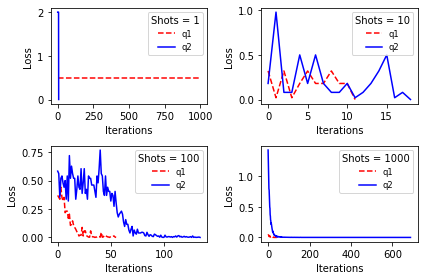

In [218]:
fig = plt.figure()
for i in range(len(shots)):
    ax = fig.add_subplot(len(shots)**0.5, len(shots)/len(shots)**0.5, i+1)
    ax.plot(range(len(loss[i][0])), loss[i][0], 'r--')
    ax.plot(range(len(loss[i][1])), loss[i][1], 'b-')
    ax.legend(['q1', 'q2'], title="Shots = "+str(shots[i]), loc=1, fontsize='small', fancybox=True)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
fig.tight_layout()

In [153]:
#the combined circuit using optimized parameters of q1 and q2
def circuit(t1, t2):
    qc = QuantumCircuit(2)
    qc.ry(t1[0], 0)
    qc.rx(t1[1], 0)
    qc.ry(t2[0], 1)
    qc.rx(t2[1], 1)
    qc.cx(0,1)
    qc.measure_all()
    qc.draw()
    return qc

#### Note
After running gradient descent on different number shots, the final probability histogram is plotted with 1000 shots and noise for all the calculated states so that we can compare which experimental setup(shot count) produces best results.

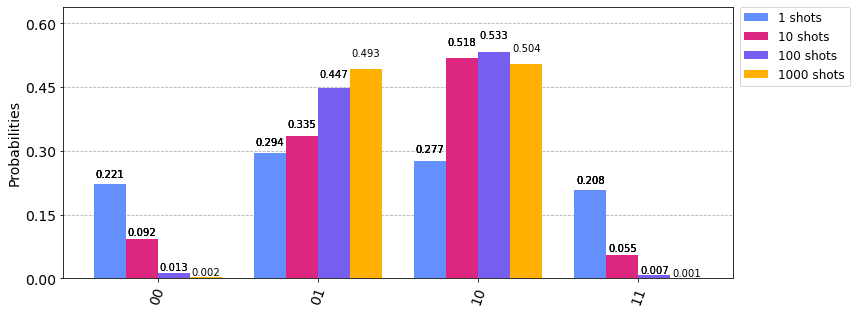

In [219]:
plots = []
legend = []
for i in range(len(shots)):
    circ = circuit(thetas[i][0], thetas[i][1])
    plot = execute(circ, backend = backend, shots=1000).result().get_counts()
    plots.append(plot)
    legend.append(str(shots[i])+ " shots")

plot_histogram(plots, legend=legend, figsize=(12,5))

### Observations:
**1 shot measurement:** <br>
  In the measurement output of a single qubit we either get $\lvert0\rangle$ or $\lvert1\rangle$ with probability 1.<br><br>
  For q1, our target state is equidistant from $\lvert0\rangle$ and $\lvert1\rangle$ in terms of probability. The gradient descent cannot move in any particular direction because the loss is constant. Inserting values for $[P0, P1]$ as $[0,1]$ or $[1,0]$ gives a constant cost of 0.5. Thus our desired state is never achieved.<br><br>
  For q2, the values of $[P0, P1]$ we are looking for are $[0, 1]$ which is easily achieved very quickly as it is one of the only two possibilities. Even though the cost is 0, it is very unlikely we reach our desired state $\lvert1\rangle$.

**10 shot measurement:** <br>
    With 10 shots the probabilities are no more binary values. But still the accuracy of measurements is not enough to give a fair picture of actual probabilities of the state. Thus we see a very erratic cost plot for 10 shots. We do achieve 0 loss for both q1 and q2 but that does not guarantee that we achieve the desired state which is evident from the histogram plot.

**100 shot measurement:** <br>
    The cost decreases smoothly with increase in number of iterations. Even though we had introduced noise, increasing the number of measurements cancels the effect of noise as the noise is expected to be equally spread between the $\lvert0\rangle$ and $\lvert1\rangle$ state. The final histogram also reflects that we are getting closer to the desired state probabilities with increased number of shots
    
**1000 shot measurement:** <br>
    The plot of cost function with number of iterations is smoothest of all amongst our experiments and also the histogram plot depicts 1000 shots give the closest state to our target state with probabilities of 0.5 for both $\lvert01\rangle$ and $\lvert10\rangle$
    
These observations comply with the fact that 
$$
\begin{align*}
P_0 = \lim_{N \rightarrow \infty} \frac{N_{0}}{N}
\qquad
P_1 = \lim_{N \rightarrow \infty} \frac{N_{1}}{N}
\end{align*}
$$

where N0 is the number of |0⟩ measurement outcomes and N1 is the number of |1⟩. The measured and the actual probabilities get closer as we increase the number of measurements.

In [243]:
for i in range(len(thetas)):
    phase = atan(tan(q1.t1)*tan(q1.t2)) - atan(tan(q1.t1)/tan(q1.t2))
    phase = lambdify( [q1.t1, q1.t2], phase, "numpy" )
    print("Phase for ",str(shots[i]), " shots = ", phase(*thetas[i][0]))

Phase for  1  shots =  -0.7935688462510804
Phase for  10  shots =  0.0746990395702436
Phase for  100  shots =  -1.4767997226876837
Phase for  1000  shots =  -0.00839058676380322


In the above cell we see that the states produced for q1 have some relative phase associated with them. Thus the final combined state will be of the form
$$
\lvert\psi_{bonus}\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}e^{i\phi}\lvert10\rangle
$$

### Bonus
We are required to generate state with same probability outcomes as earlier, but we need to avoid relative phase in the generated state.
$$
\lvert\psi_{bonus}\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert10\rangle
$$

### Approach
If we could determine the phase in terms of the input parameters($[\theta_1, \theta_2]$), we could add a factor of the phase in the cost function which we try to minimize.

Consider any general qubit state:

$\lvert q\rangle = (a+ib) \lvert0\rangle + (c+id) \lvert1\rangle$

where $a^2 + b^2 + c^2 + d^2 = 1$

The coefficient of $a+ib$ can be written in its polar form $r_1e^{i\phi_1}$, where $\phi_1 = arctan(\frac{b}{a})$ and $r_1 = \sqrt{a^2+b^2}$. The phase of a complex number will be calculated symbolically using sympy.arg function

Thus,

$$
\lvert q\rangle = r_1e^{i\phi_1} \lvert 0\rangle + r_2e^{i\phi_2} \lvert 1\rangle
= e^{i\phi_1} [r_1 \lvert 0\rangle + r_2e^{i(\phi_2 – \phi_1)} |1> ]
$$

We can ignore the global phase $e^{i\phi_1}$. We are interested in minimizing the relative phase $e^{i(\phi_2-\phi_1)}$ along with minimizing our earlier defined cost function. Our new cost function becomes:
$$
Cost = (P_0 – E_0) ^2 + (P_1 – E_1) ^2 + (\phi_2-\phi_1)^2
$$
The gradients can be calculated using derivatives as $\phi_1$ and $\phi_2$ can be expressed in terms of parameters $[\theta_1, \theta_2]$.

In [224]:
def bonus_circ(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0], 0)
    qc.rx(params[1], 0)
    qc.measure_all()
    return qc

In [225]:
t1 = Symbol('t1', real=True)
t2 = Symbol('t2', real=True)
p0 = Symbol('p0', real=True)
p1 = Symbol('p1', real=True)
ry = Matrix([[cos(t1/2), -sin(t1/2)], [sin(t1/2), cos(t1/2)]])
rx = Matrix([[cos(t2/2), -I*sin(t2/2)], [-I*sin(t2/2), cos(t2/2)]])

In [233]:
fin_state = simplify(simplify(rx*ry*Matrix([1,0])))
prob = abs(fin_state).applyfunc(lambda x:x**2)
phase_bonus = arg(fin_state[1]) - arg(fin_state[0])

# add the phase term to the cost function
cost_bonus = Matrix([(p0-0.5)**2 , (p1-0.5)**2, phase_bonus**2])
cost_deriv = Matrix([Derivative(cost_bonus[0], p0).doit(), Derivative(cost_bonus[1], p1).doit()])

grad_bonus_t1 = Matrix(derive_by_array(prob, t1))
grad_bonus_t1 = cost_deriv.multiply_elementwise(grad_bonus_t1)
grad_bonus_t1 = sum(grad_bonus_t1) + Derivative(phase_bonus**2, t1).doit()
grad_bonus_t1 = lambdify( [p0, p1, t1, t2], grad_bonus_t1, "numpy" )

grad_bonus_t2 = Matrix(derive_by_array(prob, t2))
grad_bonus_t2 = cost_deriv.multiply_elementwise(grad_bonus_t2)
grad_bonus_t2 = sum(grad_bonus_t2) + Derivative(phase_bonus**2, t2).doit()
grad_bonus_t2 = lambdify( [p0, p1, t1, t2], grad_bonus_t2, "numpy" )

cost_bonus = lambdify( [p0, p1, t1, t2], sum(cost_bonus), "numpy" )

min_cost=100000 #store the minimum cost
final_params=[] #thetas corresponding to the minimum cost

params = 2*np.pi*np.random.rand(2)

**Note:** It is very unlikely that we arrive at 0 cost because even when we arrive at the correct parameters, the observed probabilities will not be exactly 0.5 each. If the probabilities happen to be 0.5 then the phase might not exactly be 0. Earlier we were able to get 0 cost because when we got closer to desired state the phase was still off from actual by small amounts, but now since we included the phase term there will be some cost added either due to measured probabilities or due to the phase. Thus we will pick the state with minimum cost as our final state

In [236]:
for i in range(1000):
    ckt = bonus_circ(params)
    res = execute(ckt, backend = backend, shots=1000).result().get_counts() 
    state = result_state(res, 1000)
    print(state)
    print("cost at step ", i, " = ", cost_bonus(*state, *params))
    if cost_bonus(*state, *params)==0:
        break
    
    if cost_bonus(*state, *params)<=min_cost:
        min_cost = cost_bonus(*state, *params)
        final_params = params
        
    updfac_t1 = grad_bonus_t1(*state, *params)
    updfac_t2 = grad_bonus_t2(*state, *params)
    grads_bon =  [updfac_t1, updfac_t2]
    params[0] -= 0.1*grads_bon[0]
    params[1] -= 0.1*grads_bon[1]
    params %= 2*np.pi
    
circ_bonus = bonus_circ(final_params)
circ_bonus.draw()

[0.193, 0.807]
cost at step  0  =  0.36694778314301457
[0.247, 0.753]
cost at step  1  =  0.2359438851290998
[0.26, 0.74]
cost at step  2  =  0.18681048016457605
[0.291, 0.709]
cost at step  3  =  0.13709749280807776
[0.328, 0.672]
cost at step  4  =  0.09506111690363037
[0.321, 0.679]
cost at step  5  =  0.09092305893403188
[0.326, 0.674]
cost at step  6  =  0.08053311011507959
[0.359, 0.641]
cost at step  7  =  0.0545900819620571
[0.398, 0.602]
cost at step  8  =  0.032086543325960414
[0.406, 0.594]
cost at step  9  =  0.02659996293655626
[0.393, 0.607]
cost at step  10  =  0.02997979780460539
[0.401, 0.599]
cost at step  11  =  0.025017484575199905
[0.448, 0.552]
cost at step  12  =  0.009521719653956737
[0.429, 0.571]
cost at step  13  =  0.013486835885442397
[0.445, 0.555]
cost at step  14  =  0.00870531373380636
[0.438, 0.562]
cost at step  15  =  0.009812047814945449
[0.479, 0.521]
cost at step  16  =  0.0025121432949168922
[0.449, 0.551]
cost at step  17  =  0.00662268133951027

cost at step  153  =  0.0010052999730707085
[0.496, 0.504]
cost at step  154  =  5.149159414995927e-05
[0.506, 0.494]
cost at step  155  =  9.287376274382466e-05
[0.488, 0.512]
cost at step  156  =  0.00030421169049528213
[0.495, 0.505]
cost at step  157  =  7.251171603438245e-05
[0.52, 0.48]
cost at step  158  =  0.0008245866248449385
[0.495, 0.505]
cost at step  159  =  6.181026636169e-05
[0.518, 0.482]
cost at step  160  =  0.0006615935803908128
[0.476, 0.524]
cost at step  161  =  0.0011574701905766546
[0.502, 0.498]
cost at step  162  =  2.3480524418256334e-05
[0.511, 0.489]
cost at step  163  =  0.0002555913094587446
[0.521, 0.479]
cost at step  164  =  0.0008899689613912689
[0.466, 0.534]
cost at step  165  =  0.002313667485616565
[0.51, 0.49]
cost at step  166  =  0.00021301869694250906
[0.533, 0.467]
cost at step  167  =  0.002185928825219096
[0.513, 0.487]
cost at step  168  =  0.0003382061513083503
[0.502, 0.498]
cost at step  169  =  8.209929203281644e-06
[0.509, 0.491]
cos

[0.516, 0.484]
cost at step  300  =  0.0005132922264342198
[0.513, 0.487]
cost at step  301  =  0.0003380000038447869
[0.5, 0.5]
cost at step  302  =  8.126035726044434e-07
[0.494, 0.506]
cost at step  303  =  7.276803993410728e-05
[0.517, 0.483]
cost at step  304  =  0.0005781908295374051
[0.509, 0.491]
cost at step  305  =  0.00016456324524785325
[0.456, 0.544]
cost at step  306  =  0.0038767490686494755
[0.455, 0.545]
cost at step  307  =  0.004050857332857756
[0.499, 0.501]
cost at step  308  =  1.8112735729560485e-05
[0.496, 0.504]
cost at step  309  =  4.777313891657081e-05
[0.463, 0.537]
cost at step  310  =  0.002755121118781105
[0.482, 0.518]
cost at step  311  =  0.000691329113302853
[0.5, 0.5]
cost at step  312  =  5.843230305282658e-05
[0.512, 0.488]
cost at step  313  =  0.0003432193305021667
[0.506, 0.494]
cost at step  314  =  0.00011288323406046124
[0.506, 0.494]
cost at step  315  =  0.00010565138675289246
[0.497, 0.503]
cost at step  316  =  4.529588656184905e-05
[0.4

[0.526, 0.474]
cost at step  460  =  0.0013522195821824015
[0.498, 0.502]
cost at step  461  =  9.799783692019342e-06
[0.493, 0.507]
cost at step  462  =  9.935980522407295e-05
[0.512, 0.488]
cost at step  463  =  0.00028842239118901487
[0.496, 0.504]
cost at step  464  =  3.413553511362419e-05
[0.474, 0.526]
cost at step  465  =  0.0013533094918731258
[0.501, 0.499]
cost at step  466  =  2.468629254351866e-06
[0.483, 0.517]
cost at step  467  =  0.000578355759589624
[0.506, 0.494]
cost at step  468  =  7.507997820743604e-05
[0.492, 0.508]
cost at step  469  =  0.00012966817947338398
[0.534, 0.466]
cost at step  470  =  0.0023152714791470097
[0.486, 0.514]
cost at step  471  =  0.00039234995483221634
[0.5, 0.5]
cost at step  472  =  1.5410312391349267e-07
[0.494, 0.506]
cost at step  473  =  7.214567300419036e-05
[0.504, 0.496]
cost at step  474  =  3.2617518297392766e-05
[0.501, 0.499]
cost at step  475  =  2.237690701149947e-06
[0.492, 0.508]
cost at step  476  =  0.00012816393559096

cost at step  607  =  0.0004577300062060172
[0.497, 0.503]
cost at step  608  =  3.198545320961862e-05
[0.503, 0.497]
cost at step  609  =  2.9755873304558096e-05
[0.469, 0.531]
cost at step  610  =  0.0019345378431868455
[0.508, 0.492]
cost at step  611  =  0.00012969170139315775
[0.502, 0.498]
cost at step  612  =  1.1303024636199215e-05
[0.492, 0.508]
cost at step  613  =  0.000131629948215118
[0.489, 0.511]
cost at step  614  =  0.00024368899052216837
[0.492, 0.508]
cost at step  615  =  0.00012825347091842588
[0.518, 0.482]
cost at step  616  =  0.0006480040097063064
[0.531, 0.469]
cost at step  617  =  0.0019233978298894335
[0.505, 0.495]
cost at step  618  =  6.083547579334514e-05
[0.492, 0.508]
cost at step  619  =  0.00014057359061523232
[0.479, 0.521]
cost at step  620  =  0.0008903799332820257
[0.51, 0.49]
cost at step  621  =  0.00020185908411219803
[0.504, 0.496]
cost at step  622  =  3.6067081615716076e-05
[0.487, 0.513]
cost at step  623  =  0.00034300503013419225
[0.493

cost at step  759  =  0.0007270539416248474
[0.508, 0.492]
cost at step  760  =  0.00014023849457247872
[0.499, 0.501]
cost at step  761  =  1.0115543967510783e-05
[0.5, 0.5]
cost at step  762  =  8.059461289249544e-06
[0.499, 0.501]
cost at step  763  =  9.61901091903806e-06
[0.49, 0.51]
cost at step  764  =  0.00020757819733458244
[0.491, 0.509]
cost at step  765  =  0.00017333901740397532
[0.531, 0.469]
cost at step  766  =  0.0019371764380402355
[0.521, 0.479]
cost at step  767  =  0.0008847109406468452
[0.501, 0.499]
cost at step  768  =  2.022571012787541e-06
[0.485, 0.515]
cost at step  769  =  0.00045000592832411854
[0.505, 0.495]
cost at step  770  =  5.123446783323703e-05
[0.499, 0.501]
cost at step  771  =  2.540070293591099e-06
[0.508, 0.492]
cost at step  772  =  0.00012861406143501713
[0.502, 0.498]
cost at step  773  =  8.04379747186162e-06
[0.496, 0.504]
cost at step  774  =  3.2004266971013595e-05
[0.49, 0.51]
cost at step  775  =  0.00020011548690415624
[0.497, 0.503]

[0.501, 0.499]
cost at step  918  =  3.6152575812753864e-05
[0.512, 0.488]
cost at step  919  =  0.00031950629125425205
[0.481, 0.519]
cost at step  920  =  0.000743429656747203
[0.507, 0.493]
cost at step  921  =  0.0001317863304499473
[0.524, 0.476]
cost at step  922  =  0.0011787125548305417
[0.456, 0.544]
cost at step  923  =  0.0038833483497413973
[0.502, 0.498]
cost at step  924  =  4.7852396469673215e-05
[0.513, 0.487]
cost at step  925  =  0.0003739990627918423
[0.51, 0.49]
cost at step  926  =  0.00022436950132974102
[0.494, 0.506]
cost at step  927  =  8.888977418474361e-05
[0.506, 0.494]
cost at step  928  =  9.144912095247824e-05
[0.498, 0.502]
cost at step  929  =  2.3007669178781843e-05
[0.478, 0.522]
cost at step  930  =  0.0009832477288151177
[0.527, 0.473]
cost at step  931  =  0.0014862510268054572
[0.532, 0.468]
cost at step  932  =  0.0020589216956465243
[0.504, 0.496]
cost at step  933  =  3.300966075786303e-05
[0.538, 0.462]
cost at step  934  =  0.002888491329811

┌────────────┐┌────────────┐ ░ ┌─┐
   q_0: ┤ RY(1.5669) ├┤ RX(2.7608) ├─░─┤M├
        └────────────┘└────────────┘ ░ └╥┘
meas_0: ════════════════════════════════╩═

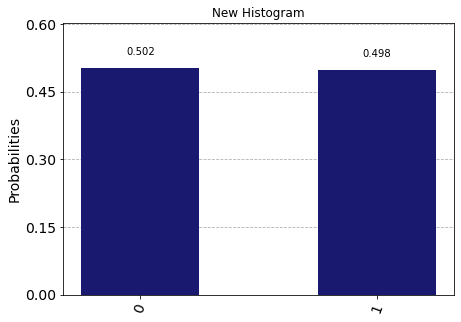

In [237]:
plot = execute(circ_bonus, backend = backend, shots=1000).result().get_counts()
plot_histogram(plot, color='midnightblue', title="New Histogram")

In [242]:
print("Final State: ", lambdify( [t1, t2], fin_state, "numpy" )(*final_params))
print("Final Phase: ",lambdify( [t1, t2], phase_bonus, "numpy" )(*final_params))

Final State:  [[0.13408382-0.69298628j]
 [0.13356731-0.6956661j ]]
Final Phase:  -0.001434523706333124


### Conclusion
We created a circuit using parameterized RX and RY gates and a constant CNOT gate. We observed that starting from state $|0\rangle$:<br>
1. Increasing the number of measurement shots improved our accuracy to achieve the target state
2. A relative phase is introduced if we define our cost function in terms of probabilities only.
3. After adding phase term in the cost function, the gradient descent moves in a direction which minimizes the probability difference as well as the relative phase.